In [2]:
from roboflow import Roboflow
import numpy as np
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
from skimage.draw import polygon
from skimage.transform import resize
import os
import glob
from argparse import ArgumentParser, Namespace

In [3]:
import code

In [4]:
def get_model():
  rf = Roboflow(api_key="ukq7YYiOr66q1oa71F0Z")
  project = rf.workspace().project("buildings-instance-segmentation")
  model = project.version(3).model
  return model


In [5]:
# infer on a local image
def get_pred(model, img_path):
  output = model.predict(img_path).json()
  predictions = output['predictions']
  prediction_df = pd.DataFrame(predictions)
  prediction_df = prediction_df.sort_values(by='confidence')
  top_coord = prediction_df.iloc[0]
  top_polygon = prediction_df['points'][0]
  return output, top_polygon

In [6]:
def show_img(img_path):
  img = imageio.imread(img_path)
  plt.imshow(img)

In [7]:

def plot_polygon(img_path, output):
  import cv2
  from google.colab.patches import cv2_imshow

  # Load the input image
  img = cv2.imread(img_path)

  # Loop through the predictions in the output
  for pred in output['predictions']:
      # Get the polygon points for the prediction
      points = pred['points']
      # Convert the points to a numpy array
      points_list = np.array([np.array([curr['x'],curr['y']]) for curr in points], dtype=np.int32)
      # Draw the polygon on the image
      cv2.polylines(img, [points_list], True, (0, 255, 0), 2)

  # Show the image with the polygons
  cv2_imshow(img)
  cv2.waitKey(0)

In [25]:
def attach_patch(img_path: str, top_poly, patch):
  img = imageio.imread(img_path)
  polygon_pts = top_poly
  p = patch
  # calculate polygon area
  poly_area = 0.5 * np.abs(np.dot(np.array(polygon_pts)[:, 0], np.roll(np.array(polygon_pts)[:, 1], 1)) -
                            np.dot(np.array(polygon_pts)[:, 1], np.roll(np.array(polygon_pts)[:, 0], 1)))
  # calculate maximum allowable patch area
  max_patch_area = 0.5 * poly_area

  # resize patch if necessary
  patch_area = p.shape[0] * p.shape[1]
  if patch_area > max_patch_area:
      scale_factor = np.sqrt(max_patch_area / patch_area)
      p_resized = resize(p, (int(scale_factor * p.shape[0]), int(scale_factor * p.shape[1])), mode='reflect', preserve_range=True, anti_aliasing=True)
  else:
      p_resized = p

  if p_resized.shape[0] % 2 != 0:
    p_resized = resize(p, (p_resized.shape[0]+1,p_resized.shape[0]+1), mode='reflect', preserve_range=True, anti_aliasing=True)

  centroid = np.array(np.mean(polygon_pts, axis=0), dtype=np.int32)

  patch_size = p_resized.shape[0]
  offset = patch_size//2
  patched_img = img.copy()
  patched_img[centroid[1]-offset:centroid[1]+offset,centroid[0]-offset:centroid[0]+offset] = p_resized
  return patched_img

In [26]:
def get_args():
  parser = ArgumentParser()
  parser.add_argument('data_path', type=str, default='/content/data')
  parser.add_argument('pgd_path', type=str, default='/content/patch.png')
  parser.add_argument('output_dir', type=str, default='/content/output')

  args = parser.parse_args()
  return args

loading Roboflow workspace...
loading Roboflow project...


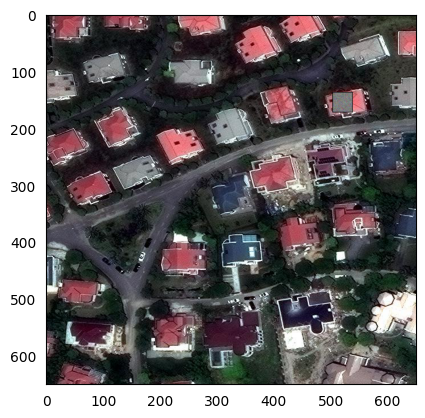

In [28]:
if __name__ == '__main__':
  model = get_model()
  args = get_args()
  # args = Namespace()
  # args.data_path = '/content/ov_img'
  # args.pgd_path = '/content/patch.png'
  # args.output_dir = '/content/output'
  dir_path = args.data_path
  output_dir = args.output_dir
  all_path = glob.glob(f'{dir_path}/*')
  patch = imageio.imread(args.pgd_path)
  for img_path in all_path:
    img_name = img_path.split('/')[-1]
    show_img(img_path)
    if patch.shape[-1]>3:
      patch = patch[:,:,0:3]
    output, top_poly = get_pred(model, img_path)
    #plot_polygon(img_path, output)
    top_poly = np.array([np.array([curr['x'],curr['y']]) for curr in top_poly], dtype=np.int32)
    patched_img = attach_patch(img_path, top_poly, patch)
    plt.imshow(patched_img)
    plt.tick_params(left = False)
    plt.tick_params(bottom = False)
    plt.savefig(f'{output_dir}/{img_name}')
